In [1]:
import os
import time
import numpy as np
import renom as rm
from tqdm import tqdm
import matplotlib.pyplot as plt

from renom_img.api.segmentation.fcn import FCN8s, FCN16s
from renom_img.api.utility.distributor.distributor import ImageDistributor
from renom_img.api.utility.augmentation import Augmentation
from renom_img.api.utility.augmentation.process import *
from renom_img.api.utility.misc.display import draw_segment
from renom_img.api.utility.evaluate import EvaluatorSegmentation

from renom.cuda import set_cuda_active
from PIL import Image
%matplotlib inline

In [2]:
set_cuda_active(True)

In [3]:
if not os.path.exists("VOCdevkit"):
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
    !tar -xvf VOCtrainval_11-May-2012.tar

In [4]:
class_map = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
             'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
             'dog', 'horse', 'motorbike', 'person', 'potted plant', 
             'sheep', 'sofa', 'train', 'tv/monitor']

In [5]:
prefix_path = '/media/hdd2/jun/dataset/VOCdevkit/VOC2012/'

In [6]:
train_image_path_list = []
train_annotation_path_list = []

with open(os.path.join(prefix_path, 'ImageSets', 'Segmentation', 'train.txt')) as f:
    txt = f.readlines()
    txt = [line.split('\n')[0] for line in txt]
    for i in range(len(txt)):
        train_image_path_list.append(os.path.join(prefix_path, 'JPEGImages', txt[i]+'.jpg'))
        train_annotation_path_list.append(os.path.join(prefix_path, 'SegmentationClass', txt[i]+'.png'))
                                          
valid_image_path_list = []
valid_annotation_path_list = []

with open(os.path.join(prefix_path, 'ImageSets', 'Segmentation', 'val.txt')) as f:
    txt = f.readlines()
    txt = [line.split('\n')[0] for line in txt]
    for i in range(len(txt)):
        valid_image_path_list.append(os.path.join(prefix_path, 'JPEGImages', txt[i]+'.jpg'))
        valid_annotation_path_list.append(os.path.join(prefix_path, 'SegmentationClass', txt[i]+'.png'))
        
print("Dataset size")
print("  Train:{}".format(len(train_image_path_list)))
print("  Valid:{}\n".format(len(valid_image_path_list)))
        

Dataset size
  Train:1464
  Valid:1449



In [7]:
# annot = np.array(Image.open(train_annotation_path_list[0]))
# draw_segment(train_image_path_list[0], annot, show_background=True)

In [8]:
fcn8s = FCN8s(np.arange(len(class_map)), imsize=(224, 224), load_pretrained_weight=True, train_whole_network=True)

In [9]:
def callback_end_epoch(epoch, model, avg_train_loss_list, avg_valid_loss_list):
    model.save('/media/hdd2/jun/checkpoints/fcn/model2_{}.hdf5'.format(epoch))

In [10]:
augmentation = Augmentation([
                Flip(),
                WhiteNoise(),
                ContrastNorm([0.5, 1.0])
            ])

In [11]:
fcn8s.fit(train_img_path_list=train_image_path_list, train_annotation_list=train_annotation_path_list,
          valid_img_path_list=valid_image_path_list, valid_annotation_list=valid_annotation_path_list, 
          batch_size=16, callback_end_epoch=callback_end_epoch, augmentation=augmentation, epoch=200)

In [12]:
fcn8s.load('/media/hdd2/jun/checkpoints/fcn/model2_109.hdf5')

In [13]:
results = fcn8s.predict(valid_image_path_list)

100%|██████████| 46/46 [00:39<00:00,  1.43it/s]

In [14]:
targets = []
for annot_path in valid_annotation_path_list:
    annot = np.array(Image.open(annot_path).resize((224, 224)))
    annot[annot >= len(class_map)] = 0
    targets.append(annot)
    
                
            

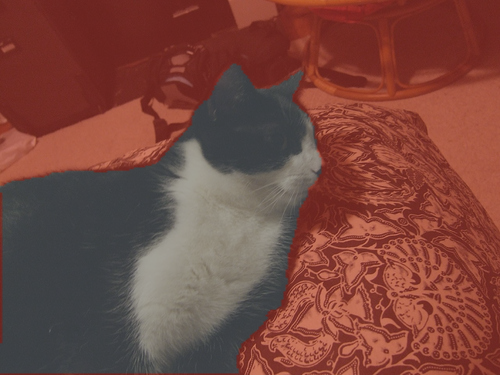

In [23]:
image_id = np.random.randint(len(valid_image_path_list))
draw_segment(valid_image_path_list[image_id], targets[image_id])

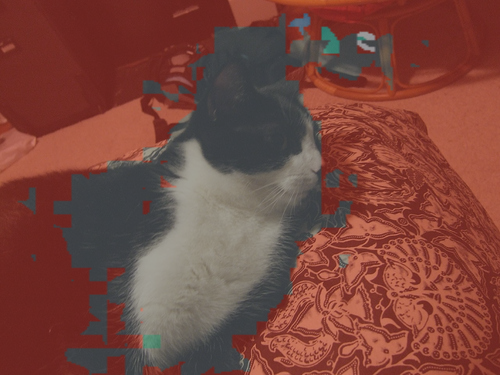

In [24]:
draw_segment(valid_image_path_list[image_id], results[image_id])

In [15]:
evaluator = EvaluatorSegmentation(results, targets)

In [18]:
evaluator.iou()

{1: 0.38299409298674403,
 2: 0.07133493423347217,
 3: 0.24908884500313375,
 4: 0.1729715964818392,
 5: 0.2167880744968459,
 6: 0.45347340791122803,
 7: 0.44346627917413634,
 8: 0.4404504372602307,
 9: 0.07008341593060076,
 10: 0.24013405630046028,
 11: 0.1841525029983308,
 12: 0.2951413707824797,
 13: 0.19029431060381718,
 14: 0.35882258639116493,
 15: 0.5175944026958249,
 16: 0.11767243620731827,
 17: 0.3261475735146702,
 18: 0.15607283671231598,
 19: 0.3418378458339668,
 20: 0.18311081141829624}